In [1]:
import numpy as np
import pandas as pd
import scipy
import sklearn
import spacy
from collections import Counter

import seaborn as sns

import re

import itertools
flatten = itertools.chain.from_iterable

from nltk.corpus import gutenberg, stopwords

from sklearn.model_selection import cross_val_score

from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
pd.options.display.max_rows = 4000

## For this challenge, you will need to choose a corpus of data from nltk or another source that includes categories you can predict and create an analysis pipeline that includes the following steps:

1. Data cleaning / processing / language parsing
2. Create features using two different NLP methods: For example, BoW vs tf-idf.
3. Use the features to fit supervised learning models for each feature set to predict the category outcomes.
4. Assess your models using cross-validation and determine whether one model performed better.
5. Pick one of the models and try to increase accuracy by at least 5 percentage points.

Let's try something that is easy to classify, like Yelp reviews. [I found this dataset on Kaggle](https://www.kaggle.com/omkarsabnis/yelp-reviews-dataset):

In [3]:
yelp_df = pd.read_csv('yelp-reviews-dataset.zip')

In [4]:
yelp_df

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0
...,...,...,...,...,...,...,...,...,...,...
9995,VY_tvNUCCXGXQeSvJl757Q,2012-07-28,Ubyfp2RSDYW0g7Mbr8N3iA,3,First visit...Had lunch here today - used my G...,review,_eqQoPtQ3e3UxLE4faT6ow,1,2,0
9996,EKzMHI1tip8rC1-ZAy64yg,2012-01-18,2XyIOQKbVFb6uXQdJ0RzlQ,4,Should be called house of deliciousness!\n\nI ...,review,ROru4uk5SaYc3rg8IU7SQw,0,0,0
9997,53YGfwmbW73JhFiemNeyzQ,2010-11-16,jyznYkIbpqVmlsZxSDSypA,4,I recently visited Olive and Ivy for business ...,review,gGbN1aKQHMgfQZkqlsuwzg,0,0,0
9998,9SKdOoDHcFoxK5ZtsgHJoA,2012-12-02,5UKq9WQE1qQbJ0DJbc-B6Q,2,My nephew just moved to Scottsdale recently so...,review,0lyVoNazXa20WzUyZPLaQQ,0,0,0


In [5]:
yelp_df.describe(include='all')

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
count,10000,10000,10000,10000.000000,10000,10000,10000,10000.000000,10000.000000,10000.000000
unique,4174,1995,10000,NaN,9998,1,6403,NaN,NaN,NaN
top,ntN85eu27C04nwyPa8IHtw,2011-03-28,wxlaY9CGArFFXzYLGBFv1w,NaN,This review is for the chain in general. The l...,review,fczQCSmaWF78toLEmb0Zsw,NaN,NaN,NaN
freq,37,21,1,NaN,2,10000,38,NaN,NaN,NaN
mean,NaN,NaN,NaN,3.777500,NaN,NaN,NaN,0.876800,1.409300,0.701300
std,NaN,NaN,NaN,1.214636,NaN,NaN,NaN,2.067861,2.336647,1.907942
min,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000
25%,NaN,NaN,NaN,3.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000
50%,NaN,NaN,NaN,4.000000,NaN,NaN,NaN,0.000000,1.000000,0.000000
75%,NaN,NaN,NaN,5.000000,NaN,NaN,NaN,1.000000,2.000000,1.000000


## Data cleaning

Drop columns we don't care about, which for this exercise is basically everything but the review text and the rating.

We can keep the business_id and use it to get an overall idea of how a business is rated, I suppose.

Cool/useful/funny might also provide some insight into the rating, so I am going to try keeping these features too.

In [6]:
yelp_df.drop(['date','review_id','type','user_id'],axis='columns',inplace=True)

```
# Let's just look at 500 rows until we get a better idea of what we're doing.
# Otherwise rerunning the parsing thing takes forever
yelp_df =  yelp_df.truncate(after=500)
```

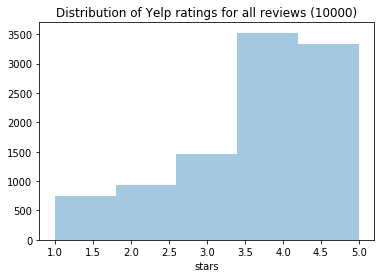

In [7]:
ax = sns.distplot(yelp_df['stars'],bins=5,norm_hist=False,kde=False)\
             .set_title('Distribution of Yelp ratings for all reviews ({})'.format(yelp_df.shape[0]))

In [46]:
# Utility function for standard text cleaning.
def text_cleaner(text):
# Remove double dashes
    text = re.sub(r'--',' ',text)
# Strip lines encased in brackets
    text = re.sub("[\[].*?[\]]", "", text)
# Random asterisks and dollar signs appear throughout
    text = re.sub('[\*\$]*', '', text)
# Remove lines that are nothing but spaces and digits
    text = re.sub(r'^\s*[0-9]+\s*$', '', text,flags=re.M)
# Strip EOF characters
    text = re.sub(r"\x1a","",text)

    text = " ".join(text.split())
    return text

In [9]:
yelp_df['text'] = yelp_df['text'].apply(lambda x: text_cleaner(x))

## Bag of Words setup

In [10]:
nlp = spacy.load('en')

In [11]:
yelp_df['parsed_text'] = yelp_df['text'].apply(lambda x: nlp(x))

In [12]:
yelp_df['parsed_text']

0       (My, wife, took, me, here, on, my, birthday, f...
1       (I, have, no, idea, why, some, people, give, b...
2       (love, the, gyro, plate, ., Rice, is, so, good...
3       (Rosie, ,, Dakota, ,, and, I, LOVE, Chaparral,...
4       (General, Manager, Scott, Petello, is, a, good...
                              ...                        
9995    (First, visit, ..., Had, lunch, here, today, -...
9996    (Should, be, called, house, of, deliciousness,...
9997    (I, recently, visited, Olive, and, Ivy, for, b...
9998    (My, nephew, just, moved, to, Scottsdale, rece...
9999    (4, -, 5, locations, .., all, 4.5, star, avera...
Name: parsed_text, Length: 10000, dtype: object

In [13]:
# Utility function to create a list of the 2000 most common words.
def bag_of_words(text):
    
    # Filter out punctuation and stop words.
    allwords = [token.lemma_
                for token in text
                if not token.is_punct
                and not token.is_digit
                and not token.is_stop]
    
    # Return the most common words.
    return [item[0] for item in Counter(allwords).most_common(200)]

In [14]:
common_words = bag_of_words(list(flatten(yelp_df['parsed_text'])))

In [15]:
common_words

['good',
 'place',
 'food',
 'like',
 'great',
 'time',
 'order',
 'go',
 'come',
 'service',
 'try',
 'love',
 'get',
 'think',
 'eat',
 'nice',
 'little',
 'look',
 'restaurant',
 'know',
 'want',
 'price',
 'find',
 'drink',
 'thing',
 'pretty',
 'wait',
 'menu',
 'bar',
 'people',
 'night',
 'friendly',
 'way',
 'staff',
 'day',
 'taste',
 'chicken',
 'table',
 'feel',
 'friend',
 'ask',
 'salad',
 'right',
 'say',
 'pizza',
 'need',
 'cheese',
 'sauce',
 'lot',
 'delicious',
 'experience',
 'work',
 'hour',
 'star',
 'take',
 'lunch',
 'bad',
 'meal',
 'fry',
 'enjoy',
 'fresh',
 'well',
 'sandwich',
 'sure',
 'definitely',
 'review',
 'dish',
 'tell',
 'area',
 'year',
 'location',
 'bit',
 'serve',
 'new',
 'flavor',
 'sit',
 'small',
 'amazing',
 'happy',
 'big',
 'beer',
 'visit',
 'walk',
 'favorite',
 'burger',
 'dinner',
 'store',
 'leave',
 'check',
 'minute',
 'give',
 'recommend',
 'home',
 'Phoenix',
 'bring',
 'special',
 'server',
 'clean',
 'tasty',
 'long',
 'wine',

In [16]:
# Creates a data frame with features for each word in our common word set.
# Each value is the count of the times the word appears in each sentence.
def bow_features(sentences, common_words):
    
# Scaffold the data frame and initialize counts to zero.
    df = pd.DataFrame(columns=common_words)
    df['text_sentence'] = sentences['parsed_text']
    df['text_source'] = sentences['stars']
    df.loc[:, common_words] = 0

# Process each row, counting the occurrence of words in each sentence.
    for i, sentence in enumerate(df['text_sentence']):
        
# Convert the sentence to lemmas, then filter out punctuation,
# stop words, and uncommon words.
        words = [token.lemma_
                 for token in sentence
                 if (
                     not token.is_punct and
                     not token.is_stop
                     and token.lemma_ in common_words
                 )]
# Capture the amount of punctuation (check the length of this list)
        punctuation = [token.lemma_
                       for token in sentence
                       if token.is_punct]

        capwords = 0
    
# Populate values for individual word count
        word_count = Counter(words)
        for word in word_count:
            df.loc[i,word] = word_count[word]

# Capture words in all caps that are longer than two characters.
# We don't want to capture numbers, or Spacy's own PRON token for pronouns, or numbers--
# Austen is apparently fond of mentioning years, which look the same in all caps ;)
            if ((word == str.upper(word)) &
               (word != '-PRON-') & 
               (len(word) > 2) &
               (not word.isnumeric())):
                capwords += 1
            
# Add sentence-level word count, punctuation
        df.loc[i,'sentence_length'] = len(sentence)
        df.loc[i,'sentence_punctuation'] = len(punctuation)
        df.loc[i,'sentence_capwords'] = capwords

# This counter is just to make sure the kernel didn't hang.
        if i % 50 == 0:
            print("Processing row {}".format(i))
            
    return df

In [17]:
word_counts = bow_features(yelp_df[['parsed_text','stars']], common_words)

Processing row 0
Processing row 50
Processing row 100
Processing row 150
Processing row 200
Processing row 250
Processing row 300
Processing row 350
Processing row 400
Processing row 450
Processing row 500
Processing row 550
Processing row 600
Processing row 650
Processing row 700
Processing row 750
Processing row 800
Processing row 850
Processing row 900
Processing row 950
Processing row 1000
Processing row 1050
Processing row 1100
Processing row 1150
Processing row 1200
Processing row 1250
Processing row 1300
Processing row 1350
Processing row 1400
Processing row 1450
Processing row 1500
Processing row 1550
Processing row 1600
Processing row 1650
Processing row 1700
Processing row 1750
Processing row 1800
Processing row 1850
Processing row 1900
Processing row 1950
Processing row 2000
Processing row 2050
Processing row 2100
Processing row 2150
Processing row 2200
Processing row 2250
Processing row 2300
Processing row 2350
Processing row 2400
Processing row 2450
Processing row 2500
Pro

Add cool/funny/useful features from the dataset to the bag of words dataframe:

In [18]:
word_counts = pd.concat([word_counts,yelp_df[['cool','funny','useful']]],axis='columns')

## Supervised learning models (using bag of words)

These models all perform about the same--which is to say, not very well. 

I started off running with just the first 500 reviews, until I was sure I processed the text correctly. When I threw the entire 10,000 record dataset at these models, I noticed the scores went up significantly, and overfitting was much less of an issue (the scores were much more consistent across folds for a given model).

My hope is that by incorporating tf-idf, I can improve on these scores.

In [19]:
from sklearn import ensemble
from sklearn.model_selection import train_test_split


Y = word_counts['text_source']
X = np.array(word_counts.drop(['text_sentence','text_source'], 1))

In [20]:
rfc = ensemble.RandomForestClassifier(n_estimators=100)

rfc_scores = cross_val_score(rfc, X, Y, cv=10)
print("Cross-validation scores: ",rfc_scores)

Cross-validation scores:  [0.45209581 0.43956044 0.44355644 0.43356643 0.44155844 0.46153846
 0.458      0.46192385 0.42785571 0.46740221]


In [21]:
rfc_scores.mean()

0.448705779390155

In [22]:
from sklearn.linear_model import LogisticRegression

# As I understand it, 'liblinear' is good for smaller datasets, and it can handle l1 penalty
lr = LogisticRegression(penalty='l1',multi_class='auto',solver='liblinear')

lr_scores = cross_val_score(lr, X, Y, cv=10)
print("Cross-validation scores: ",lr_scores)

Cross-validation scores:  [0.47804391 0.48651349 0.47052947 0.47352647 0.48451548 0.5004995
 0.474      0.49599198 0.46292585 0.48545637]


In [23]:
lr_scores.mean()

0.48120025325387294

In [24]:
clf = ensemble.GradientBoostingClassifier()

clf_scores = cross_val_score(clf, X, Y, cv=10)
print("Cross_validation scores: ",clf_scores)

Cross_validation scores:  [0.46506986 0.46153846 0.45354645 0.46953047 0.46053946 0.48851149
 0.46       0.46492986 0.44188377 0.46940822]


In [25]:
clf_scores.mean()

0.4634958045874306

## Tf-idf setup

Honestly, I didn't fully understand what to do here.

[This web page about the difference between TfidfTransformer and TfidfVectorizer](https://kavita-ganesan.com/tfidftransformer-tfidfvectorizer-usage-differences/#.Xc2nIFlKhqs) helped a _lot_.

In [26]:
# Start with a model similar to the one we built in the exercises
vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                             min_df=2, # only use words that appear at least twice
                             analyzer='word',
                             stop_words='english', #nlp.Defaults.stop_words, # use the same stop words as BoW?
                             lowercase=True, #convert everything to lower case
                             use_idf=True,
                             norm='l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )

In [27]:
#Applying the vectorizer
yelp_tfidf = vectorizer.fit_transform(yelp_df['text'])
print("Number of features: %d" % yelp_tfidf.get_shape()[1])

Number of features: 15791


In [28]:
yelp_tfidf.shape

(10000, 15791)

We can examine one of the reviews and the way its words were weighted, and decide whether it makes sense, before we continue.

In [29]:
yelp_df.loc[0,'text']

'My wife took me here on my birthday for breakfast and it was excellent. The weather was perfect which made sitting outside overlooking their grounds an absolute pleasure. Our waitress was excellent and our food arrived quickly on the semi-busy Saturday morning. It looked like the place fills up pretty quickly so the earlier you get here the better. Do yourself a favor and get their Bloody Mary. It was phenomenal and simply the best I\'ve ever had. I\'m pretty sure they only use ingredients from their garden and blend them fresh when you order it. It was amazing. While EVERYTHING on the menu looks excellent, I had the white truffle scrambled eggs vegetable skillet and it was tasty and delicious. It came with 2 pieces of their griddled bread with was amazing and it absolutely made the meal complete. It was the best "toast" I\'ve ever had. Anyway, I can\'t wait to go back!'

In [30]:
yelp_df.loc[0,'stars']

5

In [45]:
# get the first vector out (for the first document)
first_vector_tfidfvectorizer=yelp_tfidf[0]
 
# place tf-idf values in a pandas data frame
df = pd.DataFrame(first_vector_tfidfvectorizer.T.todense(), index=vectorizer.get_feature_names(), columns=["tfidf"])
df.sort_values(by=["tfidf"],ascending=False)
 

,tfidf
excellent,0.264846
quickly,0.220870
griddled,0.206575
overlooking,0.180857
fills,0.174122
...,...
famed,0.000000
familiar,0.000000
familiarity,0.000000
families,0.000000


We have over 15,000 features now! In the exercises, we used SVD to reduce the number of features. I think this might make it easier for a random forest model (as one example) to handle the dataset.

In [32]:
X = yelp_tfidf
Y = yelp_df['stars']

In [33]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

#Our SVD data reducer.  We are going to reduce the feature space from 1379 to 130.
svd = TruncatedSVD(130)
#lsa = make_pipeline(svd, Normalizer(copy=False))

I'm interested to see whether applying SVD improves cross-validation scores for the same models I tried earlier.

In [34]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty='l2',multi_class='auto',solver='saga')

lr_scores = cross_val_score(lr, X, Y, cv=10)
print("Cross-validation scores: ",lr_scores)

Cross-validation scores:  [0.51896208 0.4995005  0.4985015  0.53046953 0.51848152 0.51248751
 0.513      0.53707415 0.50601202 0.53460381]


In [35]:
lr_scores.mean()

0.5169092619067854

Logistic regression performs well. I wanted to try some different parameters and a different solver, to see whether I could improve on its results.

In [36]:
lr = LogisticRegression(penalty='l2',multi_class='auto',solver='lbfgs',max_iter=1000)

lr_scores = cross_val_score(lr, X, Y, cv=10)
print("Cross-validation scores: ",lr_scores)

Cross-validation scores:  [0.51896208 0.4995005  0.4985015  0.53046953 0.51848152 0.51248751
 0.512      0.53707415 0.50601202 0.53560682]


In [37]:
lr_scores.mean()

0.5169095628094936

In [38]:
rfc = ensemble.RandomForestClassifier(n_estimators=100)

rfc_scores = cross_val_score(rfc, X, Y, cv=10)
print("Cross-validation scores: ",rfc_scores)

Cross-validation scores:  [0.46606786 0.46053946 0.46253746 0.47452547 0.48651349 0.48051948
 0.467      0.48296593 0.43887776 0.48144433]


In [39]:
rfc_scores.mean()

0.4700991249280569

In [40]:
clf = ensemble.GradientBoostingClassifier()

clf_scores = cross_val_score(clf, X, Y, cv=10)
print("Cross_validation scores: ",clf_scores)

Cross_validation scores:  [0.4740519  0.49450549 0.47752248 0.4985015  0.49450549 0.48251748
 0.467      0.50400802 0.47094188 0.47642929]


In [41]:
clf_scores.mean()

0.4839983531423223

The logistic regression model is the winner for both techniques, and tf-idf gave better results than bag of words, so let's focus on that model and that data prep technique. Unfortunately, even the "winner" doesn't do very well at predicting the number of stars a review should have. :)

The solver used in logistic regression doesn't seem to have much of an effect on the results.

What if we were a little less ambitious, and only classified reviews as positive/negative instead of assigning stars?

In [47]:
Y = yelp_df['stars'].apply(lambda x: 0 if x < 4 else 1)

In [49]:
lr = LogisticRegression(penalty='l2',multi_class='auto',solver='saga')

lr_scores = cross_val_score(lr, X, Y, cv=10)
print("Cross-validation scores: ",lr_scores)

Cross-validation scores:  [0.82917083 0.82217782 0.82917083 0.818      0.829      0.825
 0.836      0.83483483 0.80880881 0.83783784]


In [50]:
lr = LogisticRegression(penalty='l2',multi_class='auto',solver='lbfgs',max_iter=1000)

lr_scores = cross_val_score(lr, X, Y, cv=10)
print("Cross-validation scores: ",lr_scores)

Cross-validation scores:  [0.82917083 0.82217782 0.82917083 0.818      0.829      0.825
 0.836      0.83483483 0.80880881 0.83783784]


In [53]:
lr_scores.mean()

0.8270000962000964

Those results certainly look better.